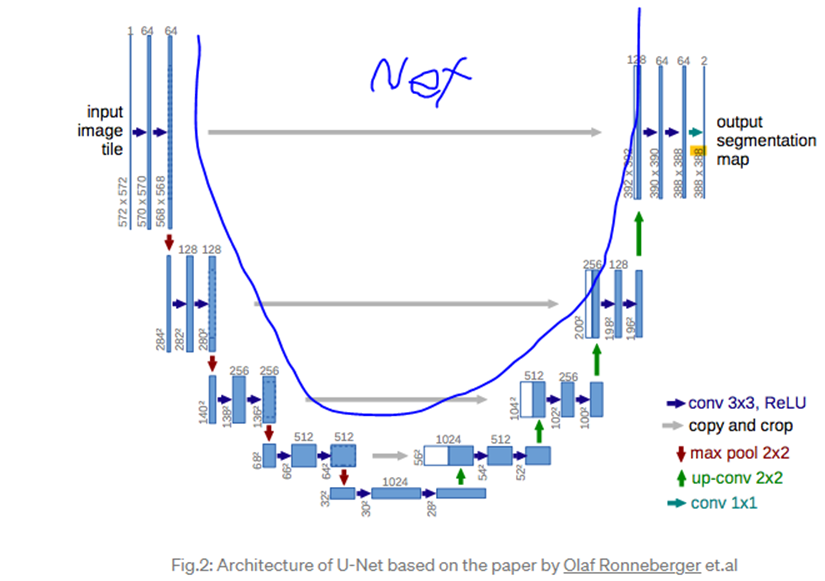

In [ ]:
!pip install NiBabel

import math
from sklearn.model_selection import train_test_split
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as T
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import InterpolationMode
from PIL import Image

import gdown
import os
import numpy as np
import matplotlib.pyplot as plt

import nibabel as nib

In [ ]:
# class unet_v1, v2, copy_crop, unet_block, upconv

class UNet_V1(nn.Module):
  def __init__(self):
    super(UNet_V1, self).__init__()

    self.ENCODER_BL1 = unet_block(1,64,1)
    self.MAXPOOL_1 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.ENCODER_BL2 = unet_block(64,128,1)
    self.MAXPOOL_2 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.ENCODER_BL3 = unet_block(128,256,1)
    self.MAXPOOL_3 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.ENCODER_BL4 = unet_block(256,512,1)
    self.MAXPOOL_4 = nn.MaxPool2d(kernel_size=2, stride=2) ##### S1: One MaxPool was enough
    self.ENCODER_BL5 = unet_block(512,1024,1)

    self.UPCONV_1 = upconv(1024,512) ##### S2: 3x3?
    self.DECODER_BL1 = unet_block(1024,512,1) ##### S3: Semantic Gap Info Passoff?
    self.UPCONV_2 = upconv(512,256)
    self.DECODER_BL2 = unet_block(512,256,1)
    self.UPCONV_3 = upconv(256,128)
    self.DECODER_BL3 = unet_block(256,128,1)
    self.UPCONV_4 = upconv(128,64)
    self.DECODER_BL4 = unet_block(128,64,1)

    self.conv_END = nn.Conv2d(64, 1, kernel_size=1, padding='0') ##### S4: 1-channel  ##### S5S1: Who said k=1?
          
  def forward(self, x): ##### C1: x:[B,C=1,H,W]
    ######## ENCODER BACKBONE

    # print("Before Encoder 1: ", x.shape)
    x1 = self.ENCODER_BL1(x)
    # print("After Encoder 1: ", x1.shape)
    m1 = self.MAXPOOL_1(x1) ##### S6S2: Creating new variables is memory inefficient ?!!!!
    # print("After Maxpool 1: ", m1.shape)

    x2 = self.ENCODER_BL2(m1)
    # print("After Encoder 2: ", x2.shape)
    m2 = self.MAXPOOL_2(x2)
    # print("After Maxpool 1: ", m2.shape)

    x3 = self.ENCODER_BL3(m2)
    # print("After Encoder 3: ", x3.shape)
    m3 = self.MAXPOOL_3(x3)
    # print("After Maxpool 1: ", m3.shape)

    x4 = self.ENCODER_BL4(m3)
    # print("After Encoder 4: ", x4.shape)
    m4 = self.MAXPOOL_4(x4)
    # print("After Maxpool 1: ", m4.shape)

    x5 = self.ENCODER_BL5(m4)
    # print("After Encoder 5: ", x5.shape)


    u1 = self.UPCONV_1(x5)
    # print("After UpConv: ", u1.shape)
    x41 = copy_crop(x4,u1)
    # print("Before Decoder 1: ", x41.shape)
    x7 = self.DECODER_BL1(x41)
    # print("After Decoder 1: ", x7.shape)

    u2 = self.UPCONV_2(x7)
    # print("After UpConv2: ", u2.shape)
    x32 = copy_crop(x3,u2)
    # print("Before Decoder 2: ", x32.shape)
    x8 = self.DECODER_BL2(x32)
    # print("After Decoder 2: ", x8.shape)

    u3 = self.UPCONV_3(x8)
    # print("After UpConv3: ", u3.shape)
    x23 = copy_crop(x2,u3)
    # print("Before Decoder 3: ", x23.shape)
    x9 = self.DECODER_BL3(x23)
    # print("After Decoder 3: ", x9.shape)

    u4 = self.UPCONV_4(x9)
    # print("After UpConv3: ", u4.shape)
    x14 = copy_crop(x1,u4)    
    # print("Before Decoder 4: ", x14.shape)
    x10 = self.DECODER_BL4(x14)
    # print("After Decoder 4: ", x10.shape)

    x_out = self.conv_END(x10)
    # print("After final convolution: ", x_out.shape)

    return x_out

"""
 # ---- V2 IMPLMENTATION ---- #
 #:v2
 # Description: 
 # ... This version alters the convolutional blocks to rebuild an image of the same size as the original.
 # ... This caters to an attempt at image segmenatation based on the UNet Architecture
"""
class UNet_V2(nn.Module):
  def __init__(self):
    super(UNet_V2, self).__init__()

    ###-------------------------- ENCODER STAGE ------------------------ ###
    ######## ENCODER BLOCK 1 : - Sequential definition:
    self.ENCODER_BL1 = unet_block(1,64,2)
    # MaxPool1: Output dims = .5 Input dims
    self.MAXPOOL_1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

    ######## ENCODER BLOCK 2 : - Sequential definition:
    self.ENCODER_BL2 = unet_block(64,128,2)
    # MaxPool2: Output dims = .5 Input dims
    self.MAXPOOL_2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

    ####### DROPOUT LAYER #######
    # self.drop1 = nn.Dropout(p = .5, inplace = False)

    ######## ENCODER BLOCK 3 :
    # Enocder block 3 - Sequential definition:
    self.ENCODER_BL3 = unet_block(128,256,2)
    # MaxPool3: Output dims = .5 Input dims
    self.MAXPOOL_3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

    ######## ENCODER BLOCK 4 : - Sequential definition:
    self.ENCODER_BL4 = unet_block(256,512,2)
    # MaxPool4: Output dims = .5 Input dims
    self.MAXPOOL_4 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

    ####### DROPOUT LAYER #######
    self.drop2 = nn.Dropout(p = .5, inplace = False)
    
    # Encoder to Decoder transition...

    ######## ENCODER BLOCK 5 : Sequential definition:
    self.ENCODER_BL5 = unet_block(512,1024,2)
    
    ###------------------------- SEMANTIC GAP ---------------------------###

    # For UNet++ this would include a bunch of convolutions

    #--------------------------- DECODER STAGE --------------------------- #
    # Decoder Stage ... 

    # UpConv1: 3x3 inchannels 1024, outchannels 512
    self.UPCONV_1 = upconv(1024,512)

    # Semantic Gap Info Passoff 4 ....
    # Concatinate = ENCODER_BL4 output + ENCODER_BL5 output 

    ######## DECODER BLOCK 1 : - Sequential definition:
    self.DECODER_BL1 = unet_block(1024,512,2)

    # UpConv2: 3x3 inchannels 512, outchannels 256
    self.UPCONV_2 = upconv(512,256)

    # Semantic Gap Info Recieve 3 ....

    ######## DECODER BLOCK 2 : - Sequential definition:
    self.DECODER_BL2 = unet_block(512,256,2)
    
    # UpConv3: 3x3 inchannels 256, outchannels 128
    self.UPCONV_3 = upconv(256,128)

    ####### DROPOUT LAYER #######
    # self.drop3 = nn.Dropout(p = .5, inplace = False)    

    # Semantic Gap Info Recieve 2 ....

    ######## DECODER BLOCK 3 : - Sequential definition:
    self.DECODER_BL3 = unet_block(256, 128,2)

    # UpConv4: 3x3 inchannels 128, outchannels 64
    self.UPCONV_4 = upconv(128,64)

    # Semantic Gap Info Recieve 1 ....

    ####### DECODER BLOCK 4 - Sequential definition:
    self.DECODER_BL4 = unet_block(128,64,2)

    # Conv9c: 1x1 inchannels 64, outchannels 1
    self.conv_END = nn.Sequential(
      nn.Conv2d(64, 1, kernel_size=1,  dilation = 1, stride=1, padding=0)
    ) 

    # Initialize the weights
    self._initialize_weights()
  
  def _initialize_weights(self) -> None:
    for module in self.modules():
        if isinstance(module, nn.Conv2d):
            torch.nn.init.xavier_uniform_(module.weight)
            # nn.init.normal_(module.weight.data, 0.0, math.sqrt(2 / (module.out_channels * module.weight.data[0][0].numel())))
            nn.init.zeros_(module.bias.data)

  def forward(self, x):
    # ----  IMPLEMENTATION ---- #
    ######## ENCODER BACKBONE  
    # print("Before Encoder 1: ", x.shape)
    x1 = self.ENCODER_BL1(x)
    # print("After Encoder 1: ", x1.shape)
    m1 = self.MAXPOOL_1(x1)
    # print("After Maxpool 1: ", m1.shape)

    # Passoff x1
    # print("Before Encoder 2: ", m1.shape)
    x2 = self.ENCODER_BL2(m1)
    # print("After Encoder 2: ", x2.shape)
    m2 = self.MAXPOOL_2(x2)
    # print("After Maxpool 2: ", m2.shape)

    # Passoff x2

    # print("Before Encoder 3: ", m2.shape)
    x3 = self.ENCODER_BL3(m2)
    # print("After Encoder 3: ", x3.shape)
    m3 = self.MAXPOOL_3(x3)
    # print("After Maxpool 3: ", m3.shape)

    # Passoff x3
    # print("Before Encoder 4: ", m3.shape)
    x4 = self.ENCODER_BL4(m3)
    # print("After Encoder 4: ", x4.shape)
    m4 = self.MAXPOOL_4(x4)
    # print("After Maxpool 4: ", m4.shape)

    # Passoff x4
    # print("Before Encoder 5: ", m4.shape)
    x5 = self.ENCODER_BL5(self.drop2(m4))
    # print("After Encoder 5: ", x5.shape)

    ######## SEMANTIC GAP 


    ######## DECODER SECTION 
    # print("Before UpConv: ", x5.shape)
    u1 = self.UPCONV_1(x5) 
    # print("After UpConv: ", u1.shape)

    x41 = copy_crop(x4,u1)

    # print("Before Decoder 1: ", x41.shape)
    x7 = self.DECODER_BL1(x41)
    # print("After Decoder 1: ", x7.shape)

    # print("Before UpConv2: ", x7.shape)
    u2 = self.UPCONV_2(x7)
    # print("After UpConv2: ", u2.shape)

    x32 = copy_crop(x3,u2)

    # print("Before Decoder 2: ", x32.shape)
    x8 = self.DECODER_BL2(x32)
    # print("After Decoder 2: ", x8.shape)

    # print("Before UpConv3: ", x8.shape)
    u3 = self.UPCONV_3(x8)
    # print("After UpConv3: ", u3.shape)

    x23 = copy_crop(x2,u3)

    # print("Before Decoder 3: ", x23.shape)
    x9 = self.DECODER_BL3(x23)
    # print("After Decoder 3: ", x9.shape)

    # print("Before UpConv4: ", x9.shape)
    u4 = self.UPCONV_4(x9)
    # print("After UpConv3: ", u4.shape)

    x14 = copy_crop(x1,u4)
    
    # print("Before Decoder 4: ", x14.shape)
    x10 = self.DECODER_BL4(x14)
    # print("After Decoder 4: ", x10.shape)

    x_out = self.conv_END(x10)
    # print("After final convolution: ", x_out.shape)

    return x_out

def copy_crop(enc_out, up_conv):
    enc_out_crop = T.functional.crop(enc_out,
                                      0,0, # Crop from origin ##### S7S3: Origin?!!!
                                      up_conv.shape[2], # Trim photo to dimensions of x6
                                      up_conv.shape[2]) ##### S8: shape[-1]    
    dec_in = torch.cat((up_conv,enc_out_crop),1) ##### C2: concat over channels
    return dec_in

def unet_block(inchannels,outchannels,version):
  # Reduce down image dimensions as in the original paper
  if version == 1:
    return nn.Sequential(
        nn.Conv2d(inchannels , outchannels, kernel_size=3, padding=0),
        nn.ReLU(True),
        nn.Conv2d(outchannels, outchannels, kernel_size=3, padding=0),
        nn.ReLU(True)
      ) 
  # Modify the convolutions to retain and rebuild the original dimensions
  elif version == 2:
    return nn.Sequential(
        nn.Conv2d(inchannels , outchannels, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.Conv2d(outchannels, outchannels, kernel_size=3, padding=1),
        nn.ReLU(True)
      ) 
    
def upconv(inchannels,outchannels):
  return nn.Sequential( ##### S9S4: k=2?!! 
        nn.Conv2d(inchannels, outchannels, kernel_size=2, stride=1, padding=1, dilation =2), 
        nn.Upsample(scale_factor=2,mode ='bilinear',align_corners=False)
    )

In [ ]:
# ConvTranspose2d
# # With square kernels and equal stride
# m = nn.ConvTranspose2d(16, 33, 3, stride=2)
# # non-square kernels and unequal stride and with padding
# m = nn.ConvTranspose2d(16, 33, (3, 5), stride=(2, 1), padding=(4, 2))
# input = torch.randn(20, 16, 50, 100)
# output = m(input)
# # exact output size can be also specified as an argument
input = torch.randn(1, 16, 12, 12)
downsample = nn.Conv2d(16, 16, 3, stride=2, padding=1)
upsample = nn.ConvTranspose2d(16, 16, 3, stride=2, padding=1)
h = downsample(input)
print(h.size())
output = upsample(h) # , output_size=input.size() #################################### we need conv2dtranspose
print(output.size())

In [ ]:
# Notes:
# print(type(input))
# print("\n Input tensor: \t\t\t", input.shape)
# T.functional.crop(input,t,l,h,w) .shape
# F.pad(input,(0,0,0,0,4,5,0,0)) .shape  # starts padding from last dim: left right then top bottom ...

# directorys = ["input/","masks/","preds/"]
# ImageReferences = []
# print(os.getcwd())
# for pwds in directorys:
#   os.chdir(pwds)
#   ImageReferences.append(os.listdir())
#   os.chdir(os.pardir)

# !rm -rf preds
# !mkdir preds

# self.encBlocks = nn.ModuleList([Block(channels[i],channels[i+1]) for i in range(len(channels)-1)])
# def forward(self,x):
#     for blocks in self.encBlocks:
#       x = blocks(x)
#       trans.append(x)
#       x = self.pool(x)

# self.upconv = nn.ModuleList([nn.ConvTranspose2d(channels[i],channels[i+1],kernel_size=2,stride=2) for i in range(len(channels)-1)])
# def crop(self,encTrans,x): ...
# encTrans = self.crop(encFeat[i],x)
# encTrans = T.CenterCrop([H,W])(encTrans)

In [ ]:
"""
  # Class name: CT_Slices_Dataset
  # Parameters:
  #     - CT_Scan (ndarray): 3D volume with a number of image slices  
  #     - image_size (int): dimensions of each slice
  # Description:
  #     Create a custom data loader to manage out CT scan slices to feed into network
  """  

from matplotlib import image

class CT_Slices_Dataset(Dataset):

  def __init__(self, Masks, CT_Scan, image_size, transforms=None, target_transforms = None):
    super(CT_Slices_Dataset, self).__init__()

    # Pre specified transforms to improve network reading
    self.transforms = transforms
    self.target_transforms = target_transforms
    self.image_size = image_size

    # CT scans    
    self.images = []
    # CT Scan Masks
    self.img_labels = []
    
    # Iterate through each slice and append it to the list of images 
    for i in range(CT_Scan.shape[0]):
      self.images.append(CT_Scan[i]) # Add image
      self.img_labels.append(Masks[i]) # Add corresponding mask


  def __len__(self):
        return len(self.images)

  def __getitem__(self, batch_index: int):
    # For now this will only have one batch

    # Make sure we don't exceed the set of images
    if batch_index < self.__len__():

      # Apply transforms if we made them
      if self.transforms == None:
        CT_Slice = self.images[batch_index]
      else: 
        # # No preprocessing w/out greyscale
        CT_Slice = self.transforms(self.images[batch_index])


      # Apply transforms if we made them
      if self.target_transforms == None:
        Mask = self.img_labels[batch_index]
      else: 

        # # No preprocessing w/out greyscale
        Mask = self.transforms(self.img_labels[batch_index])

    # If we do return an empty image
    else: 
      return np.zeros_like(self.image_size,self.image_size), np.zeros_like(self.image_size,self.image_size)

    # Return the CT_Slice and Maks on the index of image in this batch?
    return CT_Slice , Mask

In [ ]:
""" 
Step 2: Create / Load in Data
"""

from google.colab import files

# ---- Quick helper function ---- #
def typeAndShape(input):
  print(type(input),input.shape)

# ---- Generate a list of image files ----- #
# Need to check if images need to be reloaded
# Also acts as references for reading the image and converting it to ndarray later on
numImages = 3

inputCTs = []
LungMasks = []

for i in range(numImages):
  inputCTs.append("I0"+str(i+1)+".nii.gz")
  LungMasks.append("M0"+str(i+1)+".nii.gz")

# ---- DATA IMPORTS ---- #
#### Adapted from Soheils provided boiler plate imports Images_Main.ipynb ####
for i in range(numImages):

  # If any of the images don't exist load them in again
  if(os.path.exists(inputCTs[i]) == False or os.path.exists(LungMasks[i]) == False ):    
    # Break the loop don't check again
    uploaded = files.upload()
    """
    The only way I could access the files from colab was by accessing the local onedrive share file and adding images to the session
    """
    for fn in uploaded.keys():
      # This will prompt for document upload on local machine
      print('User uploaded file "{name}" with length {length} bytes'.format( name=fn, length=len(uploaded[fn])))
    
  break

print(inputCTs, LungMasks)

['I01.nii.gz', 'I02.nii.gz', 'I03.nii.gz'] ['M01.nii.gz', 'M02.nii.gz', 'M03.nii.gz']


In [ ]:
""" 
"""

# ---- DATA IMPORTS -> DATALOADER ---- #

ims = []
lngmsks = []

# Option 1 use one image
# Take in first images from uploaded files

ims_ndarr = np.swapaxes(nib.load(inputCTs[0]).get_fdata(),0,2)
lngmsks_ndarr = np.swapaxes(nib.load(LungMasks[0]).get_fdata(),0,2)

# typeAndShape(ims_ndarr)

all = False

# Option 2 add all images together --- CURRENTLY DOESNT WORK
if all:

  # Concatenate the remaining images along the height of the scans
  # Dims = [*Scanheight*5, *Voxel W, *Voxel H]
  for i in range(numImages):
    ims.append(np.swapaxes(nib.load(inputCTs[i]).get_fdata(),0,2))
    lngmsks.append(np.swapaxes(nib.load(LungMasks[i]).get_fdata(),0,2))

  # # print(ims[0])

  # ims_ndarr = np.concatenate((ims[0],ims[1],ims[2]),axis = 0)
  # lngmsks_ndarr = np.concatenate((lngmsks[0],lngmsks[1],lngmsks[2]),axis = 0)

im_ndarr = ims_ndarr
vs_ndarr = lngmsks_ndarr

typeAndShape(im_ndarr)
typeAndShape(vs_ndarr)

# CTmean = np.mean(im_ndarr)
# CTstd = np.std(im_ndarr)

# print(CTmean,CTstd)

<class 'numpy.ndarray'> (355, 512, 512)
<class 'numpy.ndarray'> (355, 512, 512)


In [ ]:
""" 
"""

from torch.nn.modules.activation import Tanh
    
# ---- DATA TRANSFORMATION ---- #

# CT_Scan trnsformations

CT_Scan_transforms =T.Compose(
    [
     # define your data augmentation HERE. You can start by uncomment the following line
      # transforms.ToPILImage(),
      T.ToTensor(),
      # T.Normalize(CTmean,CTstd),
      # transforms.Grayscale(),
      # transforms.Resize(size = (324,324), interpolation= InterpolationMode.BILINEAR),
      # transforms.RandomRotation(degrees = 30)
     ])

# Mask transformations
Mask_transforms = T.Compose(
    [
     # define your data augmentation HERE. You can start by uncomment the following line
    #  transforms.ToPILImage(),
     T.ToTensor(),
    #  transforms.Grayscale(),
    #  transforms.Resize(size = (324,324), interpolation= InterpolationMode.BILINEAR), # This is the primary alteration to allow for image output comparison
    # transforms.RandomRotation(degrees = 30)
     ])

In [ ]:
""" 
"""

im_train, im_test, vs_train, vs_test = train_test_split(im_ndarr,vs_ndarr,test_size=0.15,random_state=42)

trainData = CT_Slices_Dataset(Masks = vs_train, CT_Scan = im_train, image_size = im_ndarr.shape[1], transforms=CT_Scan_transforms, target_transforms=Mask_transforms)
trainLoader = DataLoader(trainData,shuffle=True)

testData = CT_Slices_Dataset(Masks = vs_test, CT_Scan = im_test, image_size = im_ndarr.shape[1], transforms=CT_Scan_transforms, target_transforms=Mask_transforms)
testLoader = DataLoader(testData,shuffle=True)

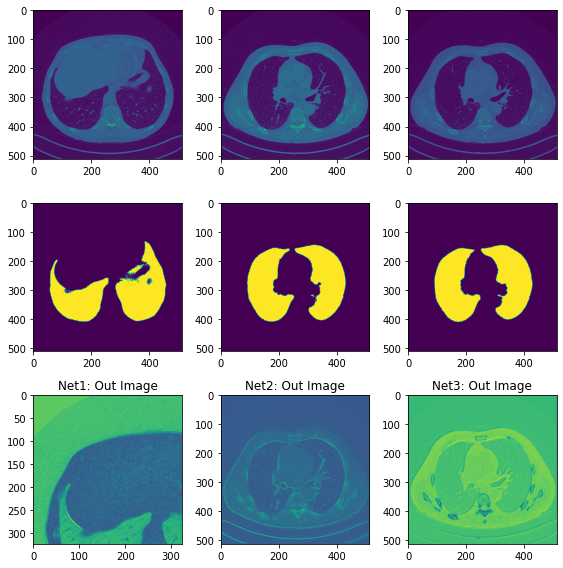

In [ ]:
""" 
Step 2.5: Visualize CT/CTA scans *If possible*
:input_data
"""

from torch._C import dtype

# Did this to re-update net everytime I tweaked optimizers
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Create two versions to test with input data
net  = UNet_V1().to(device) # This original paper implmentation reduces the image size

net2 = UNet_V2().to(device) # This version adds padding to match output

net3 = UNet().to(device) # This version made by Nat also idealizes the output but makes definition much smaller


# Quick visualization :)
fig ,ax = plt.subplots(3,3,figsize=(8,8))
fig.set_tight_layout(True)
# fig.suptitle("Scans(Row 0)     Masks(Row 1)     UNet_Outputs Test(Row 2)")
ax[2][0].set_title("Net1: Out Image")
ax[2][1].set_title("Net2: Out Image")
ax[2][2].set_title("Net3: Out Image")



# --------- NETWORK IN/OUT TESTING ------- #
for i, data in enumerate(trainLoader, 0):

  # Graph 4 instances of the input and label
  if i==3: break
  else:
    inputs, labels = data[0].to(device = device, dtype = torch.float), data[1].to(device = device, dtype = torch.float)

    ax[0][i].imshow(np.squeeze(np.squeeze(np.asarray(inputs.cpu().detach().numpy())))) 
    ax[1][i].imshow(np.squeeze(np.squeeze(np.asarray(labels.cpu().detach().numpy()))))

    if i == 0: 
      ax[2][i].imshow(np.squeeze(np.squeeze(np.asarray(net(inputs).cpu().detach().numpy()))))
    if i == 1: 
      ax[2][i].imshow(np.squeeze(np.squeeze(np.asarray(net2(inputs).cpu().detach().numpy()))))
    if i == 2: 
      ax[2][i].imshow(np.squeeze(np.squeeze(np.asarray(net3(inputs).cpu().detach().numpy()))))

# Debugging analysis
# output = net2(inputs).cpu().detach().numpy()
# masks = labels.cpu().detach().numpy()
# ins = inputs.cpu().detach().numpy()

# def npstats(x, name):
#   print("Name: ", name)
#   print("shape: ", x.shape)
#   print("uniques: ",len(np.unique(x)))
#   print("mean: ", np.mean(x))
#   print("max: ", np.max(x))
#   print("min:",np.min(x))
#   print("___________")

# npstats(ins,"inputs")
# npstats(masks,"masks")
# npstats(output,"output")

# print(torch.unique(torch.from_numpy(output)))
# output = (torch.from_numpy(output)>(np.mean(output))).float()
# print(torch.unique(output))
# print("__________")

# npstats(output.numpy(),"thresholded output")

In [ ]:
""" 
Step 3: Training setup
"""

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Drop the networks form the above visualization block
net.cpu()
net2.cpu()
net3.cpu()

# model = Unet().to(DEVICE, dtype = float)
model = UNet_V2().to(device=DEVICE, dtype = torch.float)


# UNCOMMENT FOR NETWORK PARAMTERS
# print("Total number of trainable CNN parameters=",sum([p.numel() for p in net_final.parameters()]))


################################################################################
# -------- TODO: Decide on optimal loss function and optimzers

lossfn = nn.BCEWithLogitsLoss()
learning_rate = .0006
# Idealized optimizers (From HW6 & Various trainings)
# op = optim.SGD(model.parameters(),lr = learning_rate, momentum=.75, dampening=.5, weight_decay = 0.0004)
# op =  optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay = 0.0006)
op = optim.Adam(model.parameters(), lr = learning_rate, betas = (.002,.98), eps = .35, weight_decay = 0.00065)
# op = optim.Adam(model.parameters(), lr = learning_rate, betas = (.01,.80), eps = .50, weight_decay = 0.00065)

# # Specify which optimzer here
optimizer = op

In [ ]:
"""
Condensed training function
"""

###### TRAINING HELPER FUNCTIONS (Nat)
##### TRAINING LOOP

def train_fn(loader, model, optimizer, loss_fn, scaler):
    # loop = tqdm(loader)

    for batch_idx, (data, targets) in enumerate(loader):
        data = data.to(DEVICE,dtype=torch.float)
        targets = targets.to(DEVICE,dtype=torch.float)
        targets[targets>0.0] = 1

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        # loop.set_postfix(loss=loss.item())

##### MODEL SAVING / LOADING
"""
Model saving
"""
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)
"""
Model loading
"""
def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

##### ACCURACY TESTING

"""
Accuracy of code based on Dice Score Coefficient (Sorensen-Dice Index)
"""
def check_accuracy(loader, model, device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    # Calculating 'accuracy' across the pixels by comparing to mask
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device,dtype=torch.float)
            y = y.to(device,dtype=torch.float).unsqueeze(1)
            y[y>0.0]=1
            preds = torch.sigmoid(model(x))
            preds = (preds > .2).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / ((preds + y).sum() + 1e-8)

    print(f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}")
    print(f"Dice score: {dice_score/len(loader)}")
    model.train()

##### SAVING OUTPUTS

""" 
Saving prediction images to local run time
"""    
def save_predictions_as_imgs(loader, model, folder="saved_images/", device="cuda"):
    model.eval()
    for idx, (x, y) in enumerate(loader):
        x = x.to(device=device,dtype=torch.float)
        y[y>0.0]=1
        with torch.no_grad():
          preds = torch.sigmoid(model(x))
          preds = (preds > .2).float()
        torchvision.utils.save_image(preds, f"{folder}/{idx}.png")   # Saves prediction
        torchvision.utils.save_image(y.float(), f"masks/{idx}.png")     # Saves mask
        torchvision.utils.save_image(x.float(), f"input/{idx}.png")     # Saves input
        

    model.train()

In [ ]:
"""
Step 4: Training and Validation
"""

import time

LOAD_MODEL = False
NUM_EPOCHS = 5

# Load model if available
if LOAD_MODEL:
    load_checkpoint(torch.load("my_checkpoint.pth.tar"), model)

# Check its latest accuracy
# check_accuracy(trainLoader, model, device=DEVICE)
scaler = torch.cuda.amp.GradScaler()

# Log start time
start_time = time.time()

# Begin training
for epoch in range(NUM_EPOCHS):
    
    train_fn(trainLoader, model, optimizer, lossfn, scaler)

    # save model
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer":optimizer.state_dict(),
    }
    save_checkpoint(checkpoint)

    # check accuracy
    check_accuracy(testLoader, model, device=DEVICE)

    # print some examples to a folder
    save_predictions_as_imgs(
        testLoader, model, folder="preds/", device=DEVICE)

    print("Epoch: ", epoch)

time_elap = (time.time() - start_time) // 60
print('Finished Training in %d mins' % time_elap)

=> Saving checkpoint
Got 12372203/14155776 with acc 87.40
Dice score: 0.3116733431816101
Epoch:  0
=> Saving checkpoint
Got 12655248/14155776 with acc 89.40
Dice score: 0.35610827803611755
Epoch:  1
=> Saving checkpoint
Got 13113167/14155776 with acc 92.63
Dice score: 0.42413631081581116
Epoch:  2
=> Saving checkpoint
Got 13363085/14155776 with acc 94.40
Dice score: 0.5052506327629089
Epoch:  3
=> Saving checkpoint
Got 13339480/14155776 with acc 94.23
Dice score: 0.5202738046646118
Epoch:  4
Finished Training in 5 mins


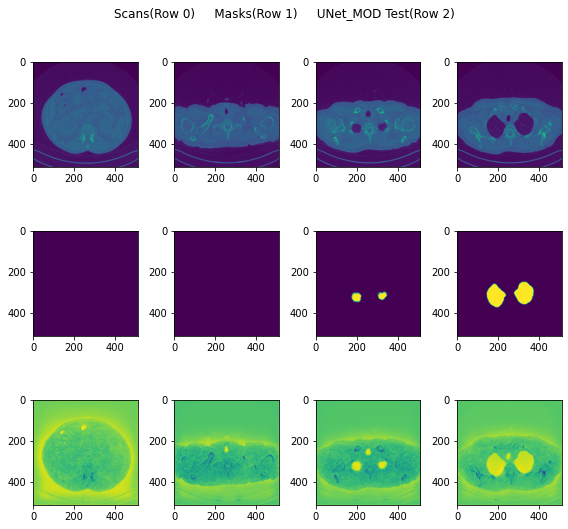

In [ ]:
"""
Step 5: Visualizing network output - Network pass through: No Threshold
"""

# --------- NETWORK IN/OUT TESTING ------- #
fig ,ax = plt.subplots(3,4,figsize=(8,8))
fig.set_tight_layout(True)
fig.suptitle("Scans(Row 0)     Masks(Row 1)     UNet_MOD Test(Row 2)")

for i, data in enumerate(testLoader, 0):

  # Graph 4 instances of the input and label
  if i==4: break
  else:
    inputs, labels = data[0].to(device = device, dtype = torch.float), data[1].to(device = device, dtype = torch.float)

    ax[0][i].imshow(np.squeeze(np.squeeze(np.asarray(inputs.cpu().detach().numpy())))) 
    ax[1][i].imshow(np.squeeze(np.squeeze(np.asarray(labels.cpu().detach().numpy()))))
    ax[2][i].imshow(np.squeeze(np.squeeze(np.asarray(model(inputs).cpu().detach().numpy()))))
